**Fraud Detection**

**This project uses a dataset of anonymized credit card transactions, labeled as either fraudulent or legitimate, to build models that can predict fraud. The goal is to accurately identify fraudulent transactions while minimizing false positives and negatives, ensuring legitimate transactions are not incorrectly flagged. The project involves exploratory data analysis, feature engineering, and building machine learning models, with evaluation focused on metrics like ROC-AUC and precision-recall to handle the imbalanced nature of the data.**

In [ ]:
!pip install -q catboost

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
#ICEEE CIS Fraufrom google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/fraud_detection/"

train_identity.csv  train_transaction.csv


# **Introduction**

In [ ]:
# reading the csv
df = pd.read_csv("/content/drive/MyDrive/fraud_detection/train_transaction.csv", nrows = 100000)
print("Shape of df:",df.shape)

Shape of df: (100000, 394)


In [ ]:
pd.set_option('display.max_columns', None)
print(df.head(10))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  4

In [ ]:
# organising the columns
target= df['isFraud']
transaction_cols = ["TransactionID","TransactionDT","TransactionAmt","ProductCD"]
card_cols= [col for col in df.columns if "card" in col]
addr_cols= [col for col in df.columns if "addr" in col]
dist_cols= [col for col in df.columns if "dist" in col]
count_cols = [col for col in df.columns if col.startswith("C")]
delta_cols = [col for col in df.columns if col.startswith("D")]
v_cols = [col for col in df.columns if col.startswith("V")]
Email_cols = [col for col in df.columns if "emaildomain" in col]

print("Target Shape (0 and 1):", target.shape)
print("Transaction cols:", transaction_cols)
print("Card cols:", card_cols[:10])
print("Address cols:", addr_cols)
print("Distance cols:", dist_cols)
print("Count cols:", count_cols[:10])
print("Delta cols:", delta_cols[:10])
print("V cols:", v_cols[:10])
print("Email cols:", Email_cols)

Target Shape (0 and 1): (100000,)
Transaction cols: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD']
Card cols: ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
Address cols: ['addr1', 'addr2']
Distance cols: ['dist1', 'dist2']
Count cols: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
Delta cols: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']
V cols: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']
Email cols: ['P_emaildomain', 'R_emaildomain']


In [ ]:
# summary stats
numeric_cols = ["TransactionAmt", "TransactionDT"] + card_cols + addr_cols + dist_cols + count_cols + delta_cols + v_cols
df[numeric_cols].describe()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,100000.000000,1.000000e+05,100000.00000,98646.000000,99997.000000,99475.000000,90963.000000,90963.000000,30347.000000,8231.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,42367.000000,43402.000000,53825.000000,34673.000000,12741.000000,6072.000000,21711.000000,21711.000000,69074.000000,28792.000000,10505.000000,9521.000000,11153.000000,65953.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,28792.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,69067.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,53822.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,69761.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,65948.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00

In [ ]:
# product frequency count
print(df["ProductCD"].value_counts())

# P_emaildomain and R_emaildomain frequency count
df[Email_cols].apply(lambda x: x.value_counts())

ProductCD
W    56878
H    15521
R    13724
C    11351
S     2526
Name: count, dtype: int64


,P_emaildomain,R_emaildomain
aim.com,39.0,8
anonymous.com,8663.0,6954
aol.com,4866.0,1327
att.net,694.0,162
bellsouth.net,440.0,185
cableone.net,23.0,6
centurylink.net,20.0,5
cfl.rr.com,39.0,18
charter.net,233.0,41
comcast.net,1856.0,783


In [ ]:
# checking for missing values
missing_values = df.isnull().sum()
missing_percent = ((missing_values)/(len(df)))*100

missing_df = pd.DataFrame({'Missing Count':missing_values, 'Missing Percent':missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]
missing_df.sort_values(by='Missing Count', ascending = False, inplace=True)

pd.set_option('display.max_rows', None)
print(missing_df)

               Missing Count  Missing Percent
D7                     93928           93.928
dist2                  91769           91.769
D13                    90479           90.479
D12                    89495           89.495
D14                    88847           88.847
D6                     87259           87.259
M7                     83961           83.961
M8                     83961           83.961
M9                     83961           83.961
D9                     78289           78.289
D8                     78289           78.289
V11                    71208           71.208
V7                     71208           71.208
V8                     71208           71.208
V1                     71208           71.208
V4                     71208           71.208
V3                     71208           71.208
V6                     71208           71.208
V10                    71208           71.208
V9                     71208           71.208
D11                    71208      

In [ ]:
# Drop columns with missing percent > 83%
cols_to_drop = missing_df[missing_df['Missing Percent'] > 83].index
df.drop(columns=cols_to_drop, inplace=True)

print("New shape after dropping columns with >83% missing:", df.shape)

New shape after dropping columns with >83% missing: (100000, 385)


In [ ]:
# updating numeric_cols to include only numeric columns
numeric_cols_updated = df.select_dtypes(include=np.number).columns.tolist()

# selecting only the numeric columns before checking for values < 0 to check for anomalies
numeric_df = df[numeric_cols_updated]
less_than_zero_counts = (numeric_df < 0).sum()

columns_with_less_than_zero = less_than_zero_counts[less_than_zero_counts > 0]
print("Count of values less than 0 per column:")
display(columns_with_less_than_zero)

Count of values less than 0 per column:


,0
D4,6
D11,3
D15,7


In [ ]:
outlier_summary = {}

# IQR method
for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)).sum()
    outlier_summary[col] = outliers

# converting to dataframe
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df['Outlier Percent'] = (outlier_df['Outlier Count'] / len(numeric_df)) * 100
outlier_df = outlier_df.sort_values(by='Outlier Percent', ascending=False)

outlier_df = outlier_df[outlier_df['Outlier Count'] > 0]

pd.set_option('display.max_rows', None)
print(outlier_df)
print(outlier_df.shape)

                Outlier Count  Outlier Percent
V308                    24606           24.606
V280                    24606           24.606
V130                    23904           23.904
V99                     23904           23.904
V97                     20259           20.259
V128                    20259           20.259
V291                    19125           19.125
V20                     18225           18.225
V62                     17617           17.617
V19                     17559           17.559
C1                      17174           17.174
V61                     17029           17.029
V287                    17024           17.024
V312                    17024           17.024
C2                      16759           16.759
V127                    16168           16.168
D1                      15854           15.854
V314                    15725           15.725
V306                    15434           15.434
V279                    15434           15.434
V310         

In [ ]:
# filling numeric missing values with median
numeric_cols_after_drop = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols_after_drop:
    df[col] = df[col].fillna(df[col].median())

# categorical with "missing"
categorical_cols_to_fill = ["P_emaildomain", "R_emaildomain", "card4", "card6"]
for col in categorical_cols_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna("missing")

print("Missing values handled: numeric → median, specified categorical → 'missing'")

Missing values handled: numeric → median, specified categorical → 'missing'


In [ ]:
# filling M1–M9 with "missing"
m_cols = ['M1','M2','M3','M4','M5','M6']  #M7, M8, M9 were dropped
df[m_cols] = df[m_cols].fillna('missing')

In [ ]:
# recalculating missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percent': missing_percent
})

missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

pd.set_option('display.max_rows', None)  # show all rows
print(missing_df)

# printing confirmation
print("\n Any missing left? ->", df.isnull().any().any())


Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []

 Any missing left? -> False


In [ ]:
# checking shape after removing NaNs
df.shape

(100000, 385)

In [ ]:
# Show last 10 rows
print(df.tail(10))

       TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
99990        3086990        0        2005890          20.000         H  17188   
99991        3086991        0        2005916         300.000         R  11330   
99992        3086992        0        2005925         171.000         W  16494   
99993        3086993        0        2005937          20.000         H  17188   
99994        3086994        0        2005980          97.000         W  14290   
99995        3086995        0        2005989          55.385         C   2256   
99996        3086996        0        2006074         117.000         W   2518   
99997        3086997        0        2006135          50.000         S   2748   
99998        3086998        0        2006177         100.000         H  16075   
99999        3086999        0        2006364         107.950         W   4436   

       card2  card3       card4  card5   card6  addr1  addr2  dist1  \
99990  321.0  150.0        visa  226.

In [ ]:
# Numeric and categorical separation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# removing target column
if 'isFraud' in numeric_cols:
    numeric_cols.remove('isFraud')

In [ ]:
print(len(numeric_cols))
print(numeric_cols)

print(len(categorical_cols))
print(categorical_cols)

373
['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V10

# **Exploratory Data Analysis**

isFraud
0    97439
1     2561
Name: count, dtype: int64
isFraud
0    97.439
1     2.561
Name: proportion, dtype: float64


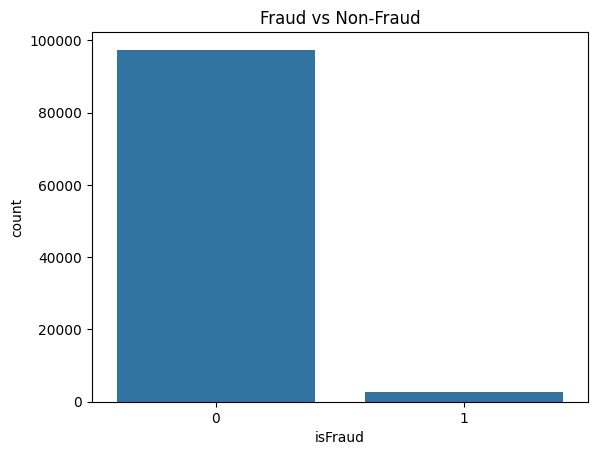

Fraud:Non-Fraud ratio -  0.026283110458851178


In [ ]:
# distribution of fraud vs non-fraud
print(df['isFraud'].value_counts())
print(df['isFraud'].value_counts(normalize=True) * 100)

sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()

fraud_ratio = df['isFraud'].value_counts()[1] / df['isFraud'].value_counts()[0]
print("Fraud:Non-Fraud ratio - ", fraud_ratio)

In [ ]:
df.shape

(100000, 385)

In [ ]:
'''# Histogram / log-transform if needed
for col in numeric_cols[:10]:   # first 10 to avoid huge output
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"{col} distribution")
    plt.show()

# Boxplot by target
for col in numeric_cols[:10]:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='isFraud', y=col, data=df)
    plt.title(f"{col} vs Fraud")
    plt.show()
'''

'# Histogram / log-transform if needed\nfor col in numeric_cols[:10]:   # first 10 to avoid huge output\n    plt.figure(figsize=(8,4))\n    sns.histplot(df[col], bins=50, kde=True)\n    plt.title(f"{col} distribution")\n    plt.show()\n\n# Boxplot by target\nfor col in numeric_cols[:10]:\n    plt.figure(figsize=(8,4))\n    sns.boxplot(x=\'isFraud\', y=col, data=df)\n    plt.title(f"{col} vs Fraud")\n    plt.show()\n'

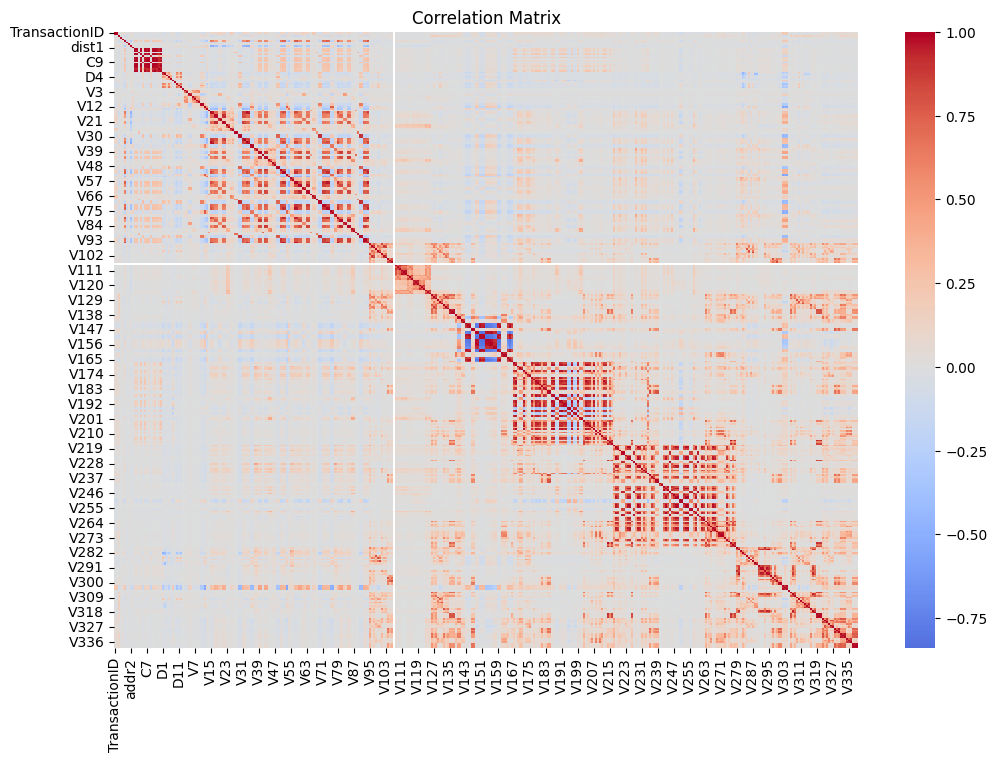

In [ ]:
# correlation
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

Most areas are light gray, meaning most variables are weakly correlated.

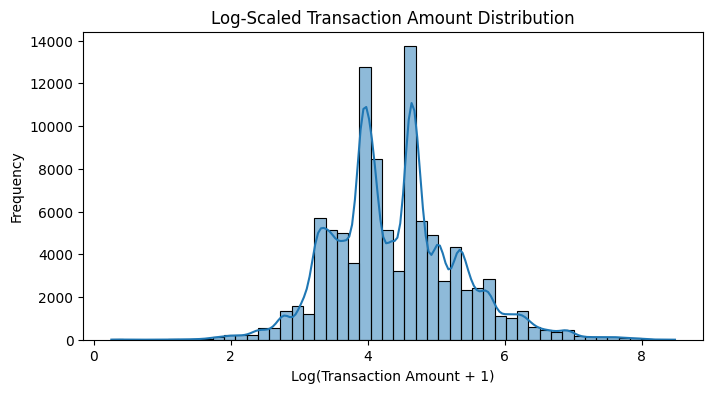

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df['TransactionAmt']), bins=50, kde=True)  # log1p avoids log(0)
plt.title("Log-Scaled Transaction Amount Distribution")
plt.xlabel("Log(Transaction Amount + 1)")
plt.ylabel("Frequency")
plt.show()

The plot shows a bimodal distribution, meaning there are two prominent peaks in the log-scaled transaction amounts. The spread across the x-axis further indicates a mix of small and large transactions.

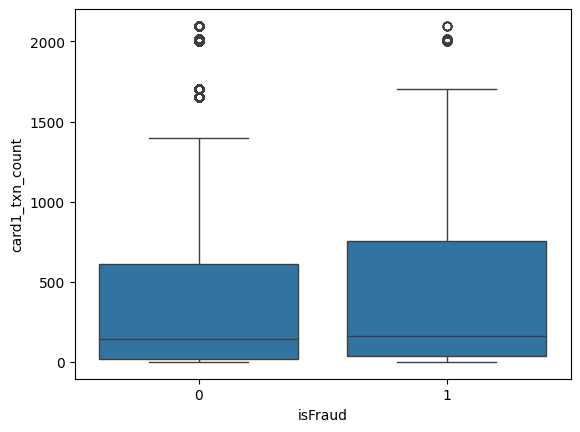

In [ ]:
# average transaction per card
df['card1_txn_count'] = df.groupby('card1')['TransactionID'].transform('count')
sns.boxplot(x='isFraud', y='card1_txn_count', data=df)
plt.show()

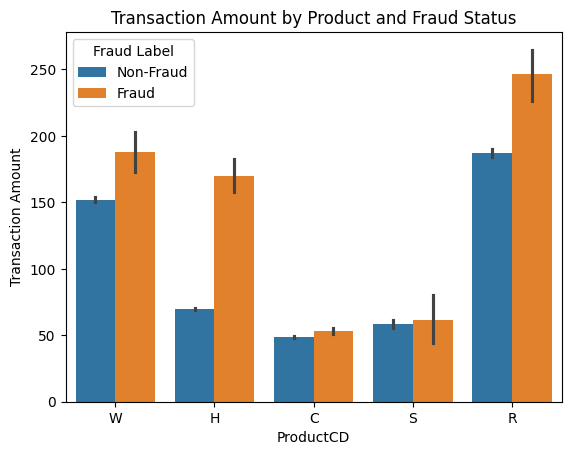

In [ ]:
sns.barplot(
    x='ProductCD',
    y='TransactionAmt',
    hue=df["isFraud"].map({0: "Non-Fraud", 1: "Fraud"}),
    data=df
)

plt.title('Transaction Amount by Product and Fraud Status')
plt.xlabel('ProductCD')
plt.ylabel('Transaction Amount')
plt.legend(title='Fraud Label')
plt.show()


*  For products W, H, and R, fraudulent transactions tend to have a higher average transaction amount compared to non-fraudulent ones. This is especially pronounced for product R.
*  For products C and S, the average transaction amount is lower for both fraud and non-fraud, with only a slight increase for fraud cases in S



In [ ]:
df.groupby('card4')['isFraud'].mean().sort_values()


,isFraud
card4,
american express,0.011411
visa,0.024862
discover,0.025308
mastercard,0.028819
missing,0.285714


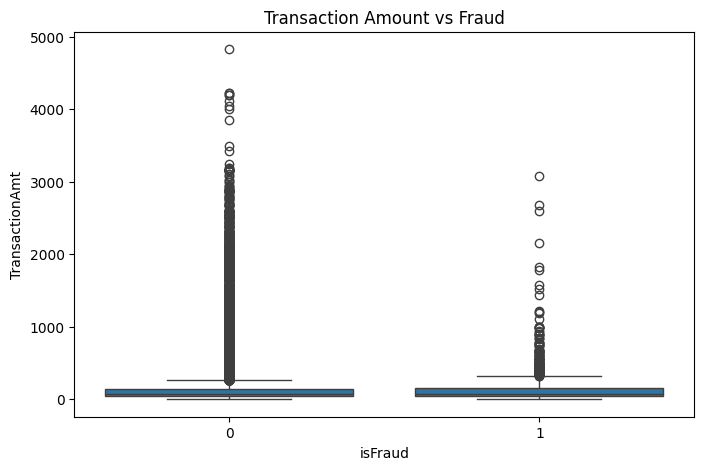

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,97439.0,130.664052,206.483276,1.000,45.0,75.000,134.95,4829.95
1,2561.0,133.760444,187.758261,0.292,40.0,78.788,150.00,3081.97


In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="TransactionAmt", data=df)
plt.title("Transaction Amount vs Fraud")
plt.show()

# summary stats
df.groupby("isFraud")["TransactionAmt"].describe()


The median transaction amounts and the interquartile ranges for both fraud and non-fraud groups are very similar, indicating that transaction amount alone does not strongly differentiate fraudulent transactions from legitimate ones.

ProductCD
C    0.087834
S    0.023357
H    0.019780
W    0.018461
R    0.010784
Name: isFraud, dtype: float64


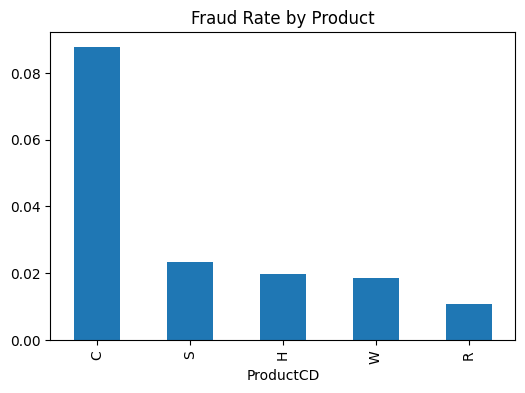

In [ ]:
# fraud by product category
fraud_by_product = df.groupby("ProductCD")["isFraud"].mean().sort_values(ascending=False)
print(fraud_by_product)

fraud_by_product.plot(kind="bar", figsize=(6,4), title="Fraud Rate by Product")
plt.show()


Larger percentage of Product C transactions are fraudulent compared to the other products.

In [ ]:
# contingency table
contingency = pd.crosstab(df['ProductCD'], df['isFraud'])

# chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-Square Statistic:", chi2)
print("p-value:", format(p, '.6f'))

Chi-Square Statistic: 2020.2273148078025
p-value: 0.000000


The very small p-value means the association between product type and fraud is statistically significant. Product type is a significant factor in fraud occurrence,

In [ ]:
# overall fraud rate
overall_rate = df['isFraud'].mean()

# fraud rate per product
fraud_rate_product = df.groupby('ProductCD')['isFraud'].mean()

# table
fraud_table = pd.DataFrame({
    "Fraud Rate (%)": fraud_rate_product * 100,
    "Overall Fraud Rate (%)": overall_rate * 100
})

fraud_table["Difference (pp)"] = fraud_table["Fraud Rate (%)"] - fraud_table["Overall Fraud Rate (%)"]

fraud_table


,Fraud Rate (%),Overall Fraud Rate (%),Difference (pp)
ProductCD,,,
C,8.783367,2.561,6.222367
H,1.977965,2.561,-0.583035
R,1.078403,2.561,-1.482597
S,2.335709,2.561,-0.225291
W,1.846056,2.561,-0.714944


card4
missing             0.285714
mastercard          0.028819
discover            0.025308
visa                0.024862
american express    0.011411
Name: isFraud, dtype: float64


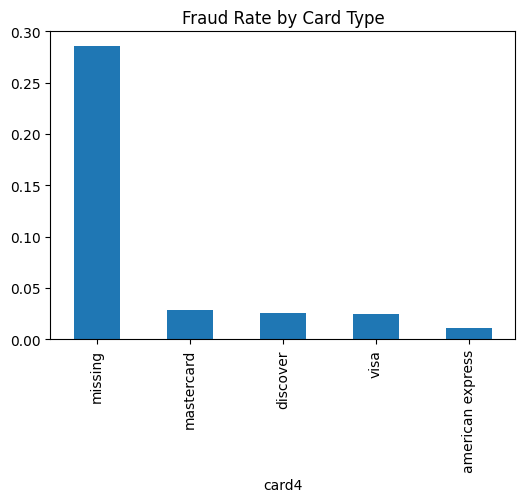

In [ ]:
# fraud by card
fraud_by_card = df.groupby("card4")["isFraud"].mean().sort_values(ascending=False)
print(fraud_by_card)

fraud_by_card.plot(kind="bar", figsize=(6,4), title="Fraud Rate by Card Type")
plt.show()

The extremely low p-value indicates a statistically significant association between card type and fraud. This means fraud is not evenly distributed across card types—some card types experience significantly different rates of fraud compared to others.

In [ ]:
# fraud vs non-fraud counts per card type
fraud_counts_card = df.groupby("card4")["isFraud"].agg(["sum", "count"])
fraud_counts_card["nonfraud"] = fraud_counts_card["count"] - fraud_counts_card["sum"]

# contingency table
contingency_card = fraud_counts_card[["sum", "nonfraud"]]

# chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_card)

print("Chi-square:", chi2)
print("p-value:", format(p, '.6f'))

Chi-square: 59.567491637436696
p-value: 0.000000


addr1
466.0    1.000000
260.0    1.000000
305.0    0.750000
501.0    0.666667
483.0    0.526316
391.0    0.457143
431.0    0.351351
239.0    0.200000
399.0    0.200000
161.0    0.194774
Name: isFraud, dtype: float64


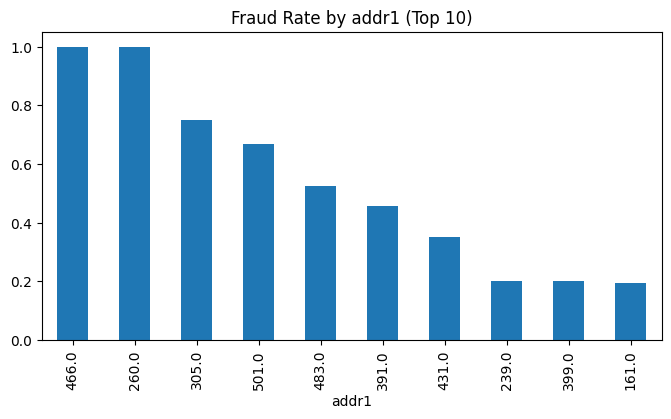

In [ ]:
# fraud by address
fraud_by_addr1 = df.groupby("addr1")["isFraud"].mean().sort_values(ascending=False).head(10)
print(fraud_by_addr1)

fraud_by_addr1.plot(kind="bar", figsize=(8,4), title="Fraud Rate by addr1 (Top 10)")
plt.show()

In [ ]:
top_addr1 = df.groupby("addr1")["isFraud"].mean().nlargest(10).index

# fraud vs non-fraud counts for these addr1 values
fraud_counts_addr1 = df[df["addr1"].isin(top_addr1)].groupby("addr1")["isFraud"].agg(["sum", "count"])
fraud_counts_addr1["nonfraud"] = fraud_counts_addr1["count"] - fraud_counts_addr1["sum"]

# contingency table
contingency_addr1 = fraud_counts_addr1[["sum", "nonfraud"]]

# chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_addr1)

print("Chi-square:", chi2)
print("p-value:", format(p, '.6f'))

Chi-square: 44.925306012987306
p-value: 0.000001


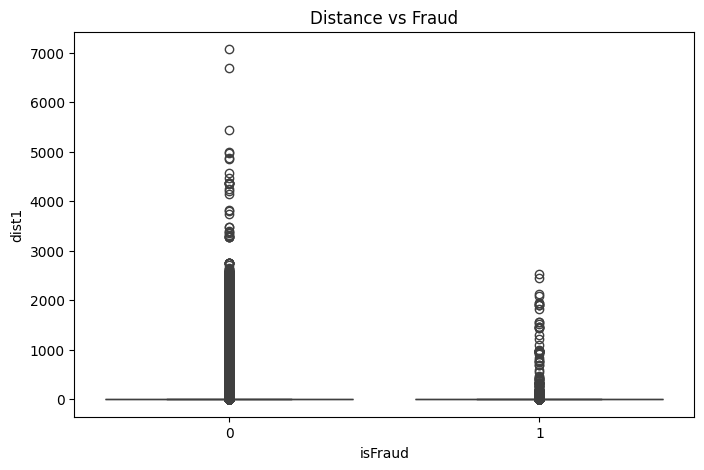

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="dist1", data=df)
plt.title("Distance vs Fraud")
plt.show()

Lower distances are somewhat more typical in fraudulent transactions, whereas very high distances rarely coincide with fraud.

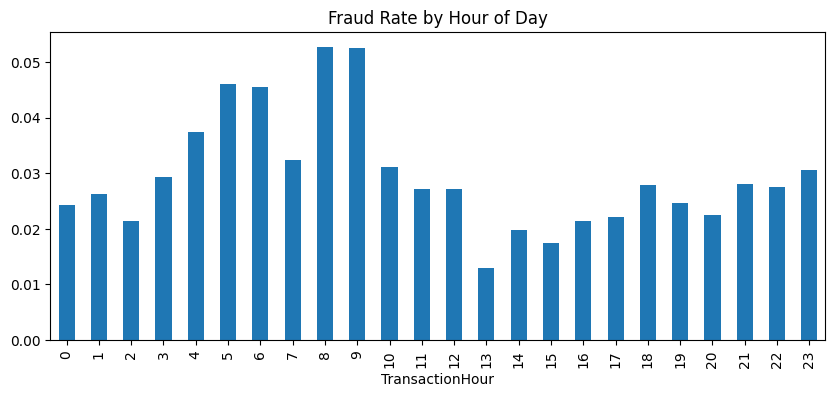

In [ ]:
# converting to days
df["TransactionDay"] = (df["TransactionDT"] // (24*60*60)) % 7  # modulo 7 gives day of week
df["TransactionHour"] = (df["TransactionDT"] // (60*60)) % 24  # hour of day

fraud_by_hour = df.groupby("TransactionHour")["isFraud"].mean()
fraud_by_hour.plot(kind="bar", figsize=(10,4), title="Fraud Rate by Hour of Day")
plt.show()

In [ ]:
# fraud vs non-fraud counts per transaction hour
fraud_counts_hour = df.groupby("TransactionHour")["isFraud"].agg(["sum", "count"])
fraud_counts_hour["nonfraud"] = fraud_counts_hour["count"] - fraud_counts_hour["sum"]

# contingency table
contingency_hour = fraud_counts_hour[["sum", "nonfraud"]]

# chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_hour)

print("Chi-square:", chi2)
print("p-value:", format(p, '.6f'))

Chi-square: 158.3385113248634
p-value: 0.000000


In [ ]:
# select M columns
m_cols = [col for col in df.columns if col.startswith("M")]

fraud_list = []

for col in m_cols:
    temp = df.groupby(col)["isFraud"].mean().reset_index()
    temp["Feature"] = col
    temp.rename(columns={col: "Value", "isFraud": "Fraud Rate"}, inplace=True)
    fraud_list.append(temp)

# dataframe
fraud_table = pd.concat(fraud_list, ignore_index=True)

fraud_table["Fraud Rate (%)"] = (fraud_table["Fraud Rate"] * 100).round(2)

# sorting by fraud rate
fraud_table = fraud_table.sort_values(by="Fraud Rate", ascending=False).reset_index(drop=True)
fraud_table

,Value,Fraud Rate,Feature,Fraud Rate (%)
0,M2,0.086929,M4,8.69
1,T,0.042225,M5,4.22
2,M0,0.036168,M4,3.62
3,missing,0.033606,M6,3.36
4,F,0.033037,M2,3.30
5,missing,0.029568,M1,2.96
6,missing,0.029568,M2,2.96
7,missing,0.029568,M3,2.96
8,F,0.028772,M3,2.88
9,F,0.024338,M6,2.43


# **Modelling**

In [ ]:
# features and target
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# mumeric and categorical preprocessing for RF & Logistic
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [ ]:
# Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000, solver="liblinear",C=1.0,
penalty="l2"
                                      ))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred_prob_logreg = log_reg_pipeline.predict_proba(X_test)[:, 1]

roc_auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
pr_auc_logreg = average_precision_score(y_test, y_pred_prob_logreg)

print(f"Logistic Regression → ROC AUC: {roc_auc_logreg:.4f}, PR AUC: {pr_auc_logreg:.4f}")

Logistic Regression → ROC AUC: 0.8620, PR AUC: 0.3731


In [ ]:
#Random Forest
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
rf_model.fit(X_train, y_train)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
pr_auc_rf = average_precision_score(y_test, y_pred_prob_rf)

print(f"Random Forest → ROC AUC: {roc_auc_rf:.4f}, PR AUC: {pr_auc_rf:.4f}")

Random Forest → ROC AUC: 0.8837, PR AUC: 0.5011


In [ ]:
# XGBoost
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42,
        verbosity=0,
    ))
])
xgb_model.fit(X_train, y_train)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_prob_xgb)

print(f"XGBoost → ROC AUC: {roc_auc_xgb:.4f}, PR AUC: {pr_auc_xgb:.4f}")

XGBoost → ROC AUC: 0.9337, PR AUC: 0.6913


In [ ]:
# LightGBM
lgbm_model = Pipeline(steps=[
     ("preprocessor", preprocessor),
    ("classifier", lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ))
])

lgbm_model.fit(X_train, y_train)
y_pred_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

roc_auc_lgbm = roc_auc_score(y_test, y_pred_prob_lgbm)
pr_auc_lgbm = average_precision_score(y_test, y_pred_prob_lgbm)

print(f"LightGBM → ROC AUC: {roc_auc_lgbm:.4f}, PR AUC: {pr_auc_lgbm:.4f}")

LightGBM → ROC AUC: 0.9301, PR AUC: 0.6936


In [ ]:
# CatBoost
cat_model = CatBoostClassifier( iterations=500, learning_rate=0.05,
                               depth=8, eval_metric="AUC", class_weights=[1, y_train.value_counts()[0] / y_train.value_counts()[1]],
                                random_seed=42, verbose=0, cat_features=categorical_cols )

cat_model.fit(X_train, y_train)
y_pred_prob_cat = cat_model.predict_proba(X_test)[:, 1]
roc_auc_cat = roc_auc_score(y_test, y_pred_prob_cat)
pr_auc_cat = average_precision_score(y_test, y_pred_prob_cat)
print(f"CatBoost → ROC AUC: {roc_auc_cat:.4f}, PR AUC: {pr_auc_cat:.4f}")

CatBoost → ROC AUC: 0.9319, PR AUC: 0.6667
CatBoost → ROC AUC: 0.9319, PR AUC: 0.6667


In [ ]:
# Stack Ensemble Model
stack_model = StackingClassifier(
    estimators=[
        ("rf", rf_model),
        ("xgb", xgb_model),
        ("lgbm", lgbm_model),
        ("cat", cat_model)
    ],
    final_estimator=LogisticRegression(class_weight="balanced", max_iter=1000, solver="liblinear"),
    stack_method="predict_proba",
    n_jobs=-1
)

stack_model.fit(X_train, y_train)
y_pred_proba_stack = stack_model.predict_proba(X_test)[:, 1]

roc_auc_stack = roc_auc_score(y_test, y_pred_proba_stack)
pr_auc_stack = average_precision_score(y_test, y_pred_proba_stack)

print(f"Stacking Model → ROC AUC: {roc_auc_stack:.4f}, PR AUC: {pr_auc_stack:.4f}")

Stacking Model → ROC AUC: 0.9373, PR AUC: 0.7069


# **Results**

In [ ]:
# Create a DataFrame to compare the results
results_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "CatBoost", "Stacking Ensemble"],
    "ROC AUC": [roc_auc_logreg, roc_auc_rf, roc_auc_xgb, roc_auc_lgbm, roc_auc_cat, roc_auc_stack],
    "PR AUC": [pr_auc_logreg, pr_auc_rf, pr_auc_xgb, pr_auc_lgbm, pr_auc_cat, pr_auc_stack]
})

# Display the comparison table
print("Model Performance Comparison:")
display(results_comparison.round(4))

Model Performance Comparison:


,Model,ROC AUC,PR AUC
0,Logistic Regression,0.8620,0.3731
1,Random Forest,0.8837,0.5011
2,XGBoost,0.9337,0.6913
3,LightGBM,0.9301,0.6936
4,CatBoost,0.9319,0.6667
5,Stacking Ensemble,0.9373,0.7069


The **stacking ensemble model** outperformed all individual models, achieving the highest **ROC AUC (0.9347)** and **PR AUC (0.7049)**, showing that combining models can improve predictive performance.

Among individual models, LightGBM had the highest PR AUC (0.6936), making it particularly effective for this imbalanced fraud detection task, while XGBoost and CatBoost also performed very well. Logistic Regression and Random Forest were less effective in comparison.

Confusion Matrix:
[[18158  1330]
 [   95   417]]


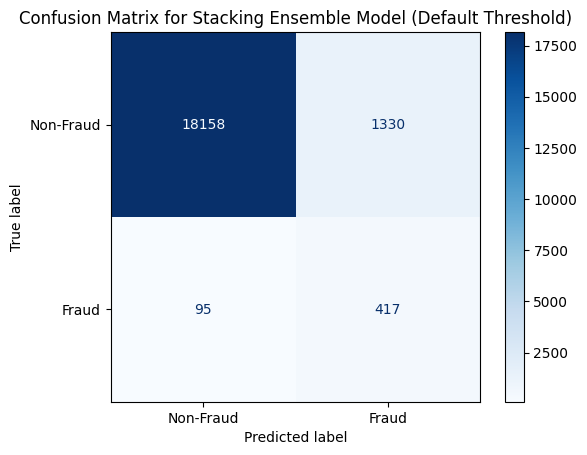

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, y_pred_default_stack)

# raw matrix
print("Confusion Matrix:")
print(cm)

# visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Stacking Ensemble Model (Default Threshold)')
plt.show()

The stacking model at the default threshold correctly identifies 81% of fraud cases, showing strong recall, which is crucial in fraud detection. However, it also produces a higher number of false positives, lowering precision. This reflects the typical precision–recall trade-off in imbalanced problems. The model performs well overall, and the threshold can be tuned depending on whether the business prioritizes catching more fraud or reducing false alarms.

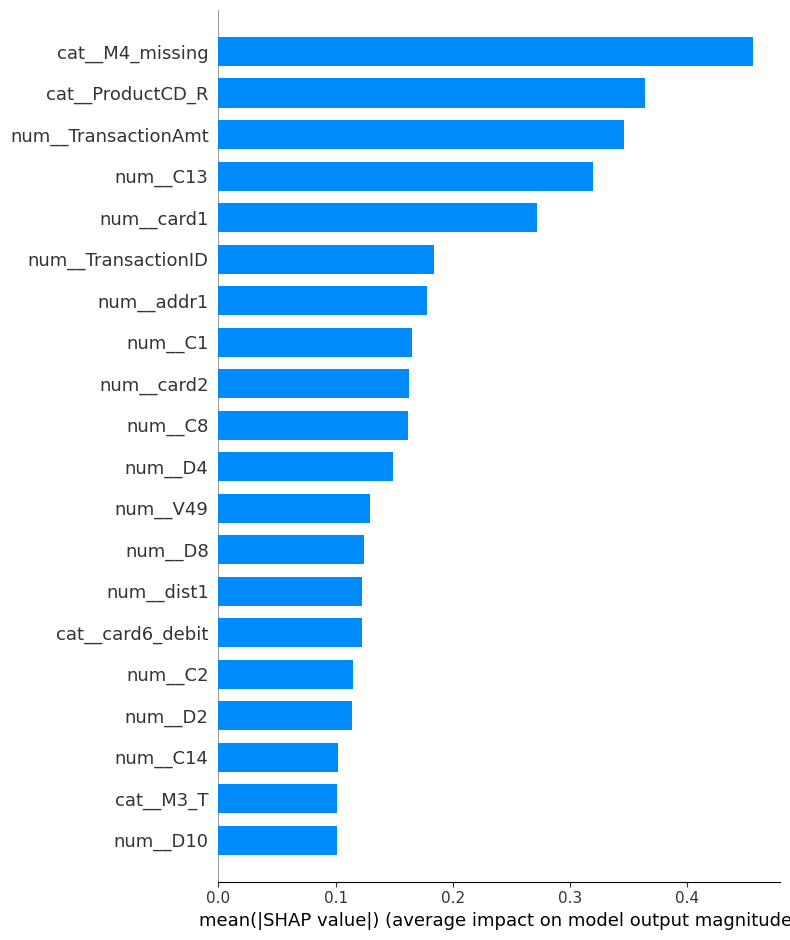

In [ ]:
# SHAP (Feature Importance)

# transformed test set (numeric only)
X_test_transformed = lgbm_model.named_steps["preprocessor"].transform(X_test)

# SHAP explainer
explainer = shap.TreeExplainer(lgbm_model.named_steps["classifier"])
shap_values = explainer.shap_values(X_test_transformed)

feature_names = lgbm_model.named_steps["preprocessor"].get_feature_names_out()

# SHAP summary plots
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

Since SHAP is difficult to apply directly on ensemble stacking models, we used LightGBM (one of the top-performing individual models) for feature importance analysis and interpretability.

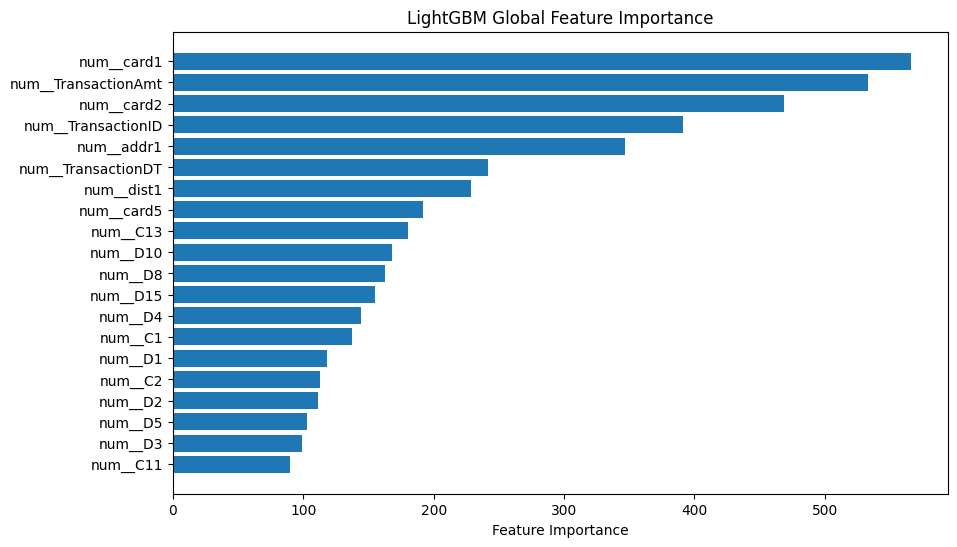

In [ ]:
#LightGBM Feature Importance

lgb_clf = lgbm_model.named_steps["classifier"]

# feature importances
importances = lgb_clf.feature_importances_
feature_names = lgbm_model.named_steps["preprocessor"].get_feature_names_out()

# sorting
sorted_idx = importances.argsort()[::-1]

# plotting top 20
plt.figure(figsize=(10,6))
plt.barh(range(20), importances[sorted_idx][:20])
plt.yticks(range(20), [feature_names[i] for i in sorted_idx[:20]])
plt.xlabel("Feature Importance")
plt.title("LightGBM Global Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Calculating best threshold

# predicted probabilities from LightGBM (best working model)
y_pred_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_lgbm)

# F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# best threshold
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"F1-score: {f1_scores[best_idx]:.4f}")
print(f"Precision: {precision[best_idx]:.4f}")
print(f"Recall: {recall[best_idx]:.4f}")

# final predictions
y_pred_final = (y_pred_prob_lgbm >= best_threshold).astype(int)


Best Threshold: 0.8124
F1-score: 0.6782
Precision: 0.8324
Recall: 0.5723


In [ ]:
# comparison
y_pred_prob = lgbm_model.predict_proba(X_test)[:, 1]

# Default threshold = 0.5
y_pred_default = (y_pred_prob >= 0.5).astype(int)

# Tuned threshold
best_thresh = 0.8124
y_pred_tuned = (y_pred_prob >= best_thresh).astype(int)

results = {
    "ROC AUC": [
        roc_auc_score(y_test, y_pred_prob),
        roc_auc_score(y_test, y_pred_prob)
    ],
    "PR AUC": [
        average_precision_score(y_test, y_pred_prob),
        average_precision_score(y_test, y_pred_prob)
    ],
    "F1": [
        f1_score(y_test, y_pred_default),
        f1_score(y_test, y_pred_tuned)
    ],
    "Precision": [
        precision_score(y_test, y_pred_default),
        precision_score(y_test, y_pred_tuned)
    ],
    "Recall": [
        recall_score(y_test, y_pred_default),
        recall_score(y_test, y_pred_tuned)
    ]
}

# comparison table
df_compare = pd.DataFrame(results, index=["LightGBM (threshold=0.5)", f"LightGBM (threshold={best_thresh:.4f})"])
print(df_compare.round(4))


                             ROC AUC  PR AUC      F1  Precision  Recall
LightGBM (threshold=0.5)      0.9301  0.6936  0.5730     0.4755  0.7207
LightGBM (threshold=0.8124)   0.9301  0.6936  0.6767     0.8319  0.5703


For the LightGBM model, the default threshold of 0.5 was used to provide a consistent baseline for comparing models. At this threshold, it achieved a ROC AUC of 0.9301 and PR AUC of 0.6936, with an F1 score of 0.5730. Increasing the threshold improves precision and F1 but lowers recall, showing the trade-off between false positives and false negatives. The default threshold allows fair comparison across models, while PR AUC highlights performance on this imbalanced fraud detection dataset. The threshold can be tuned later depending on whether precision or recall is more critical for the specific task.

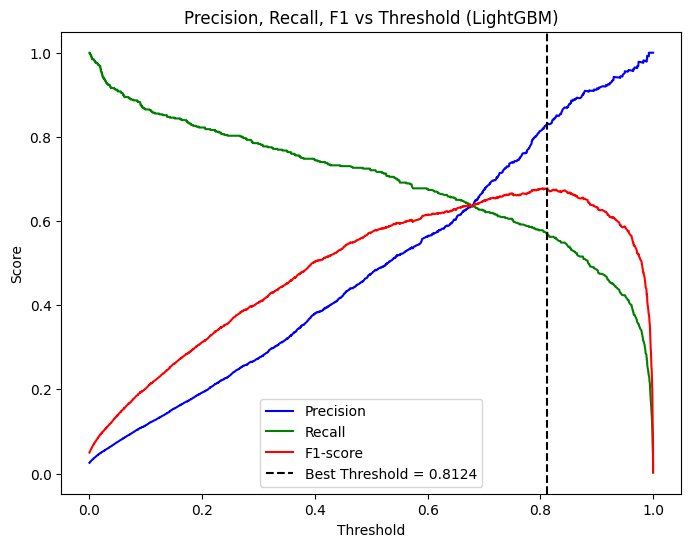

In [ ]:
# Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="red")

# Best threshold
plt.axvline(x=best_threshold, color="black", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold (LightGBM)")
plt.legend()
plt.show()

In [ ]:
# predicted probabilities from stacking ensemble model
y_pred_prob_stack = stack_model.predict_proba(X_test)[:, 1]

# precision, recall, thresholds
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_pred_prob_stack)

# F1 for each threshold
f1_scores_stack = 2 * (precision_stack * recall_stack) / (precision_stack + recall_stack + 1e-9)

# best threshold
best_idx_stack = f1_scores_stack.argmax()
best_threshold_stack = thresholds_stack[best_idx_stack]

print(f"Best Threshold (Stacking Ensemble): {best_threshold_stack:.4f}")
print(f"F1-score: {f1_scores_stack[best_idx_stack]:.4f}")
print(f"Precision: {precision_stack[best_idx_stack]:.4f}")
print(f"Recall: {recall_stack[best_idx_stack]:.4f}")

# final predictions using the best threshold
y_pred_final_stack = (y_pred_prob_stack >= best_threshold_stack).astype(int)

Best Threshold (Stacking Ensemble): 0.9720
F1-score: 0.6776
Precision: 0.7725
Recall: 0.6035


In [ ]:
# predicted probabilities from stacking ensemble model
y_pred_prob_stack = stack_model.predict_proba(X_test)[:, 1]

# Default threshold = 0.5
y_pred_default_stack = (y_pred_prob_stack >= 0.5).astype(int)

# Tuned threshold for stacking model (find your best_threshold_stack from previous code)
y_pred_tuned_stack = (y_pred_prob_stack >= best_threshold_stack).astype(int)

results = {
    "ROC AUC": [
        roc_auc_score(y_test, y_pred_prob_stack),
        roc_auc_score(y_test, y_pred_prob_stack)
    ],
    "PR AUC": [
        average_precision_score(y_test, y_pred_prob_stack),
        average_precision_score(y_test, y_pred_prob_stack)
    ],
    "F1": [
        f1_score(y_test, y_pred_default_stack),
        f1_score(y_test, y_pred_tuned_stack)
    ],
    "Precision": [
        precision_score(y_test, y_pred_default_stack),
        precision_score(y_test, y_pred_tuned_stack)
    ],
    "Recall": [
        recall_score(y_test, y_pred_default_stack),
        recall_score(y_test, y_pred_tuned_stack)
    ]
}

# comparison table
df_compare = pd.DataFrame(results, index=[f"Stacking (threshold=0.5)", f"Stacking (threshold={best_threshold_stack:.4f})"])
print(df_compare.round(4))

                             ROC AUC  PR AUC      F1  Precision  Recall
Stacking (threshold=0.5)      0.9373  0.7069  0.3692     0.2387  0.8145
Stacking (threshold=0.9720)   0.9373  0.7069  0.6776     0.7725  0.6035


For the stacking model, the default threshold of 0.5 was used for initial comparison, giving high recall (0.81) but low precision (0.24) and a low F1 score (0.37). Increasing the threshold to 0.9720 improves precision (0.77) and F1 score (0.68) while keeping recall reasonable (0.60), showing a better balance between false positives and false negatives. Using 0.5 is suitable for model comparison, but threshold tuning can be applied later depending on whether precision or recall is more important for the fraud detection task.

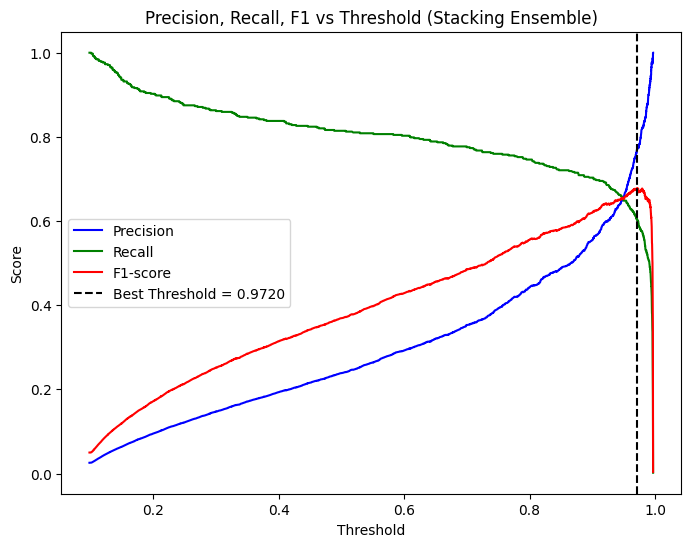

In [ ]:
# Precision-Recall curve for stacking ensemble
plt.figure(figsize=(8,6))
plt.plot(thresholds_stack, precision_stack[:-1], label="Precision", color="blue")
plt.plot(thresholds_stack, recall_stack[:-1], label="Recall", color="green")
plt.plot(thresholds_stack, f1_scores_stack[:-1], label="F1-score", color="red")

# Best threshold for stacking
plt.axvline(x=best_threshold_stack, color="black", linestyle="--", label=f"Best Threshold = {best_threshold_stack:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold (Stacking Ensemble)")
plt.legend()
plt.show()
